## Small Utility Scripts to Visualize Data

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import shelve
import os

from matplotlib import pyplot as plt

from objects import Conditions, Data, Prediction, MachineChar, EndMill
from ml import LinearModel, UnifiedLinearModel, mean_no_outliers
from optimize import Optimizer

from IPython.core.display import display, HTML
def niceprint(*args):
    display(HTML("<p>" + " ".join([str(i) for i in args]) + "</p>"))
    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120), 
     (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150), 
     (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148), 
     (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199), 
     (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau20)): 
    r, g, b = tableau20[i] 
    tableau20[i] = (r / 255., g / 255., b / 255.) 

In [3]:
# get data
data_name = '6061-sweep-wide'
data = None
with shelve.open(os.path.join("saved_cuts", "db")) as db:
    print("\n".join(list(db.keys())))
    data = db[data_name]

6061-sweep-wide
6061-optimizer
6061-sweep-speed
ammp-alu-1_4
ammp-alu-3_8
ammp-alu-1_8
ammp-alu-1_8-D_2
ammp-lcs-1_4


<IPython.core.display.Javascript object>


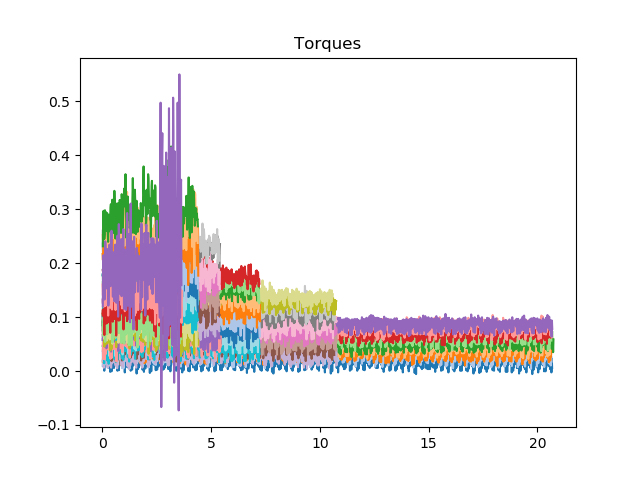

<IPython.core.display.Javascript object>


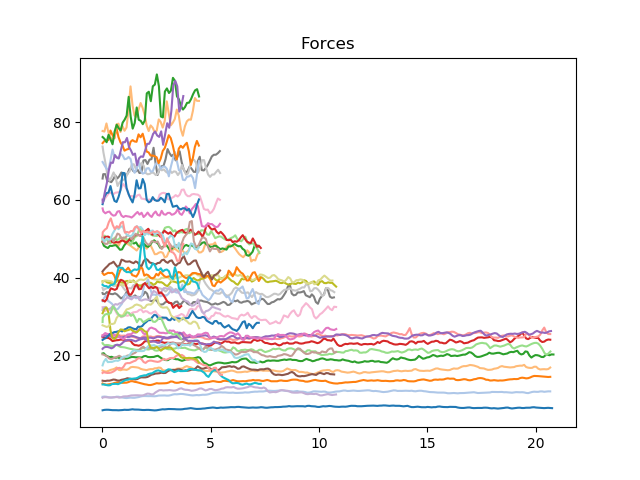

In [7]:
# graph actual data collected
plt.figure()
for i, datum in enumerate(data):
    plt.title("Torques")
    plt.plot(datum.Ts[:, 0], datum.Ts[:, 1], color = tableau20[i % 20])
    
plt.figure()

for i, datum in enumerate(data):
    plt.title("Forces")
    plt.plot(datum.Fys[:, 0], datum.Fys[:, 1], color = tableau20[i % 20])

<IPython.core.display.Javascript object>


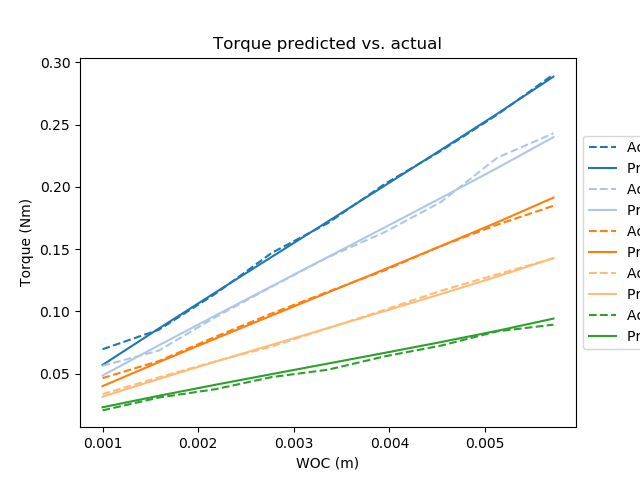

<IPython.core.display.Javascript object>


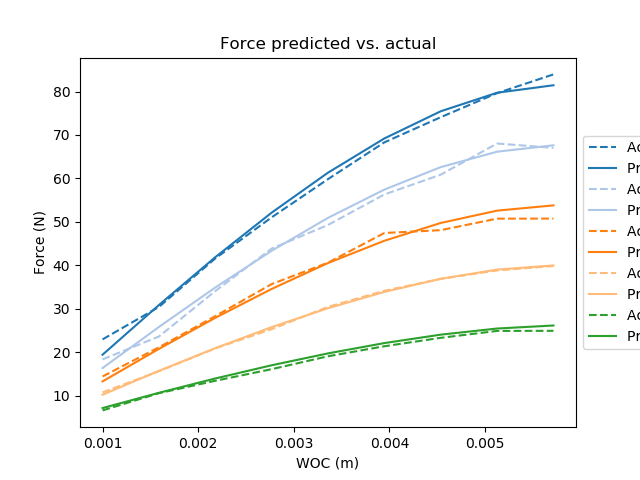

In [5]:
# sweep graphs
desired_data = data[:-4] # last sweep was a little sad
model = UnifiedLinearModel()
model.ingest_data(desired_data)
niceprint("Params: ", model.params)
niceprint("Score: ", model.score())
predictions = model.predict([datum.conditions() for datum in desired_data])

def form_dataframe_data(data):
    a = list()
    for datum in data:
        D, W, f_r, w, endmill, Ts, Fys = datum.unpack()
        a.append([D, W, f_r, w, endmill, mean_no_outliers(Ts[:, 1]), mean_no_outliers(Fys[:, 1])])
    return pd.DataFrame(a, columns = ['D', 'W', 'f_r','w', 'endmill', 'Ts', 'Fys'])

def form_dataframe_predictions(predictions):
    return pd.DataFrame([prediction.unpack() for prediction in predictions], columns = ['D', 'W', 'f_r','w', 'endmill', 'T', 'F'])

df = form_dataframe_data(desired_data)
dfp = form_dataframe_predictions(predictions)
feeds = df.f_r.unique()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
axs = [ax1, ax2]
for i, feed in enumerate(reversed(feeds)):
    is_desired = df['f_r'] == feed
    axs[0].set_title("Torque predicted vs. actual")
    axs[0].set(xlabel = "WOC (m)", ylabel = "Torque (Nm)")
    axs[0].plot(df[is_desired]['W'], df[is_desired]['Ts'], label="Actual, feed " + "{:.3f} m/s".format(feed), linestyle='--', color = tableau20[i % 20])
    axs[0].plot(dfp[is_desired]['W'], dfp[is_desired]['T'], label="Pred., feed " + "{:.3f} m/s".format(feed), color = tableau20[i % 20])
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig1.savefig('generated_assets/sweep_graphs/' + data_name + '_torques.png', dpi = 300, bbox_inches = 'tight')
    axs[1].set_title("Force predicted vs. actual")
    axs[1].set(xlabel = "WOC (m)", ylabel = "Force (N)")
    axs[1].plot(df[is_desired]['W'], df[is_desired]['Fys'], label="Actual, feed " + "{:.3f} m/s".format(feed), linestyle='--', color = tableau20[i % 20])
    axs[1].plot(dfp[is_desired]['W'], [a[1] for a in dfp[is_desired]['F']], label="Pred., feed " + "{:.3f} m/s".format(feed), color = tableau20[i % 20])
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig2.savefig('generated_assets/sweep_graphs/' + data_name + '_forces.png', dpi = 300, bbox_inches = 'tight')
    

# find average error
errors_T = list()
errors_Fy = list()
for datum, prediction in zip(desired_data, predictions):
    datum_T = np.median(datum.Ts[:, 1])
    datum_Fy = np.median(datum.Fys[:, 1])
    errors_T.append((datum_T - prediction.T) / prediction.T)
    errors_Fy.append((datum_Fy - prediction.F[1]) / prediction.F[1])
    
niceprint("Average error for T:", np.mean(np.abs(errors_T)))
niceprint("Average error for Fy:", np.mean(np.abs(errors_Fy)))

<IPython.core.display.Javascript object>


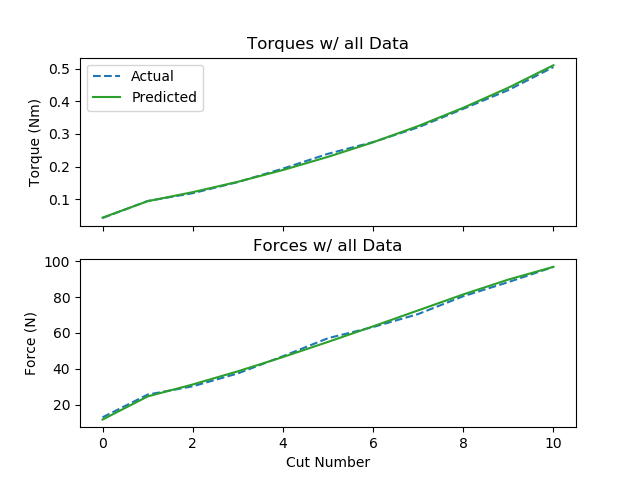

<IPython.core.display.Javascript object>


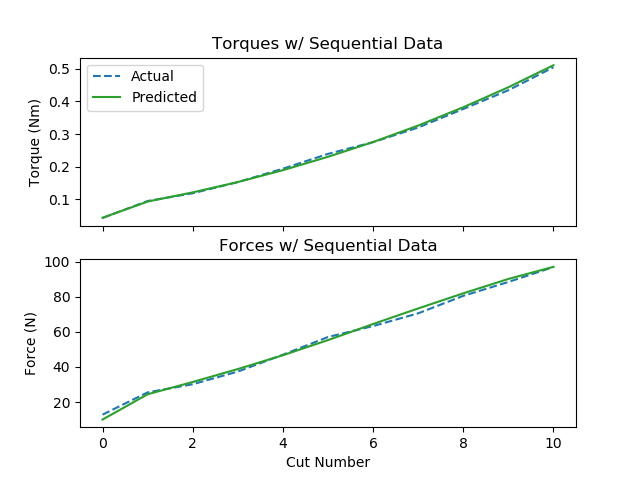

In [65]:
# analyze ammp runs
USE_OLD_RUN = 'ammp-alu-1_4'

full_name = data_name

model = UnifiedLinearModel()
if USE_OLD_RUN:
    with shelve.open(os.path.join("saved_cuts", "db")) as db:
        model.ingest_data(db[USE_OLD_RUN])
        full_name += '_using_' + USE_OLD_RUN

actual_T = [mean_no_outliers(i.Ts[:, 1]) for i in data]
actual_Fy = [mean_no_outliers(i.Fys[:, 1]) for i in data]
pred_T = []
pred_Fy = []
    
for datum in data:
    pred = model.predict_one(datum.conditions())
    pred_T.append(pred.T)
    pred_Fy.append(pred.F[1])
    model.ingest_datum(datum)

    
# fig, ax = plt.subplots(2)
fig, ax = plt.subplots(2)
ax[0].set_title("Torques w/ all Data")
ax[0].set_xlabel("Cut Number")
ax[0].set_ylabel("Torque (Nm)")
ax[0].plot(range(len(data)), actual_T, label = "Actual", linestyle='--', color = tableau20[0])
ax[0].plot(range(len(data)), [model.predict_one(d.conditions()).T for d in data], label = "Predicted", color = tableau20[4])
ax[0].legend()
ax[0].label_outer()
ax[1].set_title("Forces w/ all Data")
ax[1].set_xlabel("Cut Number")
ax[1].set_ylabel("Force (N)")
ax[1].plot(range(len(data)), actual_Fy, label = "Actual", linestyle='--', color = tableau20[0])
ax[1].plot(range(len(data)), [model.predict_one(d.conditions()).F[1] for d in data], label = "Predicted", color = tableau20[4])
plt.savefig('generated_assets/ammp_graphs/' + full_name + '_all_data.png', dpi = 300, bbox_inches = 'tight')

fig, ax = plt.subplots(2)
ax[0].set_title("Torques w/ Sequential Data")
ax[0].set_xlabel("Cut Number")
ax[0].set_ylabel("Torque (Nm)")
ax[0].plot(range(len(data)), actual_T, label = "Actual", linestyle='--', color = tableau20[0])
ax[0].plot(range(len(data)), pred_T, label = "Predicted", color = tableau20[4])
ax[0].legend()
ax[0].label_outer()
ax[1].set_title("Forces w/ Sequential Data")
ax[1].set_xlabel("Cut Number")
ax[1].set_ylabel("Force (N)")
ax[1].plot(range(len(data)), actual_Fy, label = "Actual", linestyle='--', color = tableau20[0])
ax[1].plot(range(len(data)), pred_Fy, label = "Predicted", color = tableau20[4])
plt.savefig('generated_assets/ammp_graphs/' + full_name + '_seq_data.png', dpi = 300, bbox_inches = 'tight')

<IPython.core.display.Javascript object>


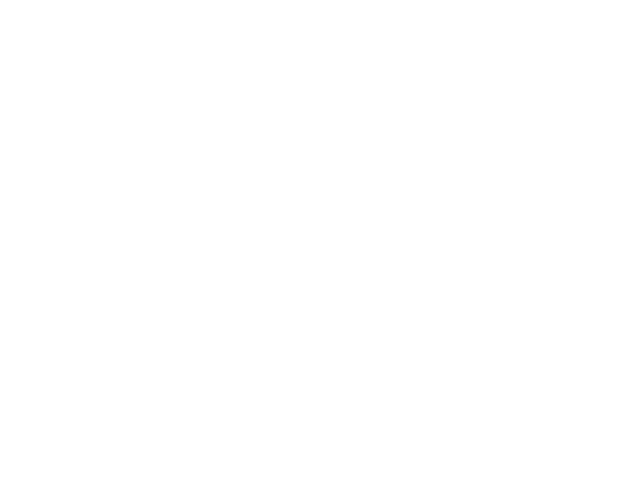

<IPython.core.display.Javascript object>


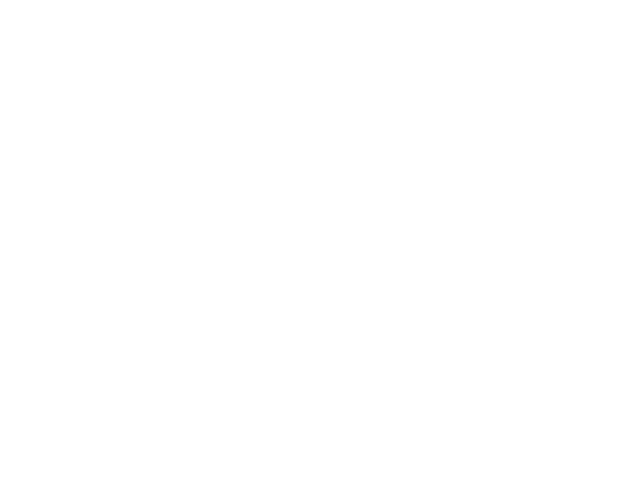

<IPython.core.display.Javascript object>


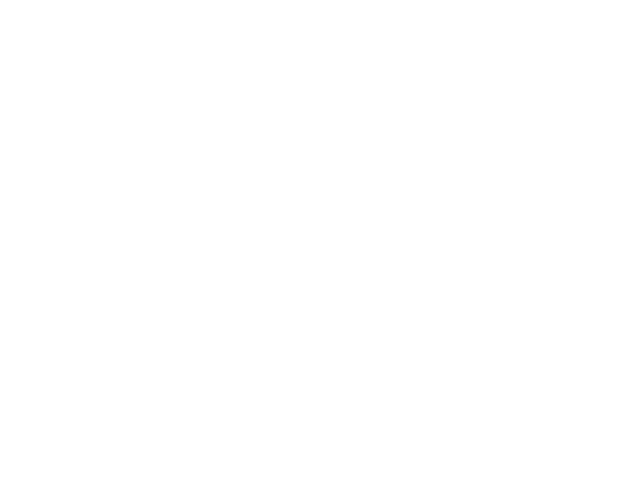

<IPython.core.display.Javascript object>


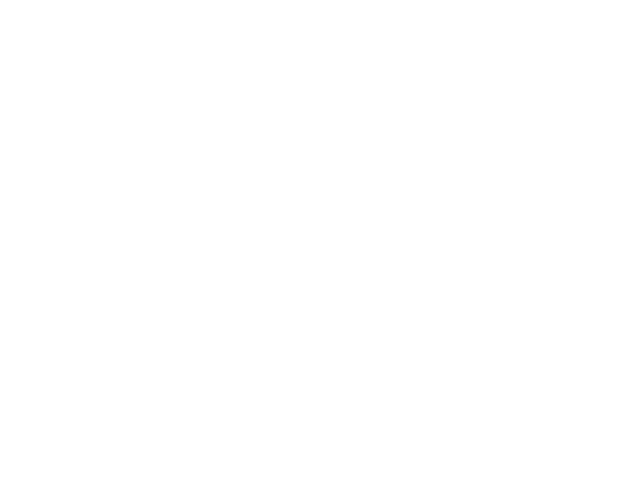

<IPython.core.display.Javascript object>


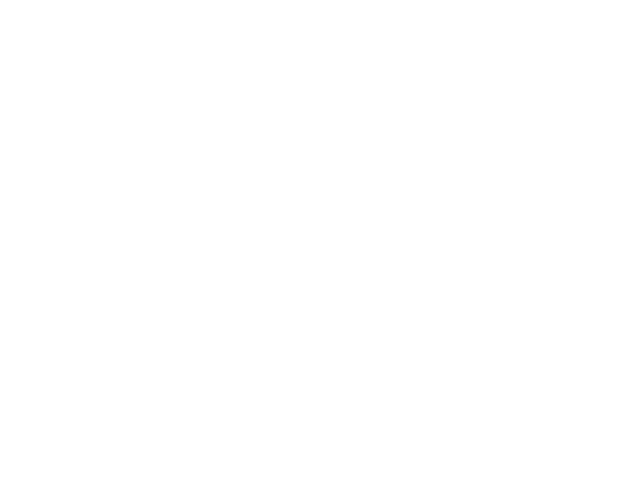

<IPython.core.display.Javascript object>


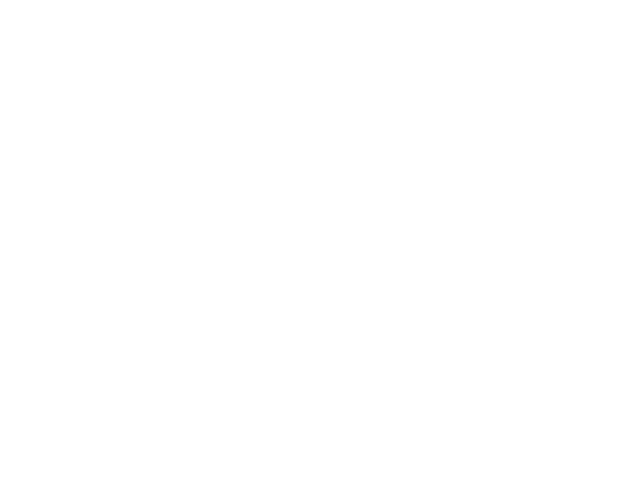

<IPython.core.display.Javascript object>


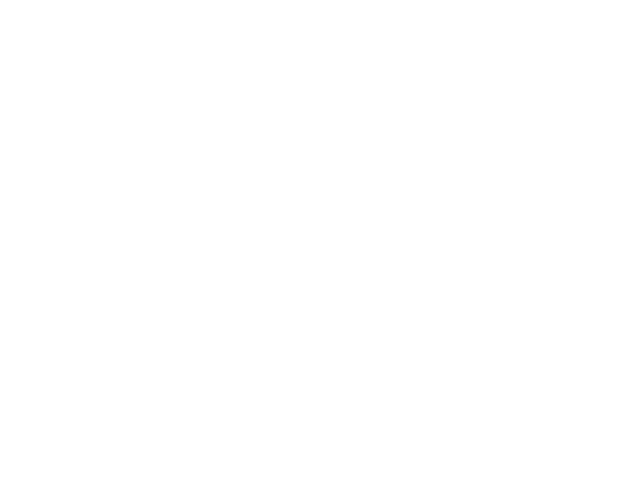

<IPython.core.display.Javascript object>


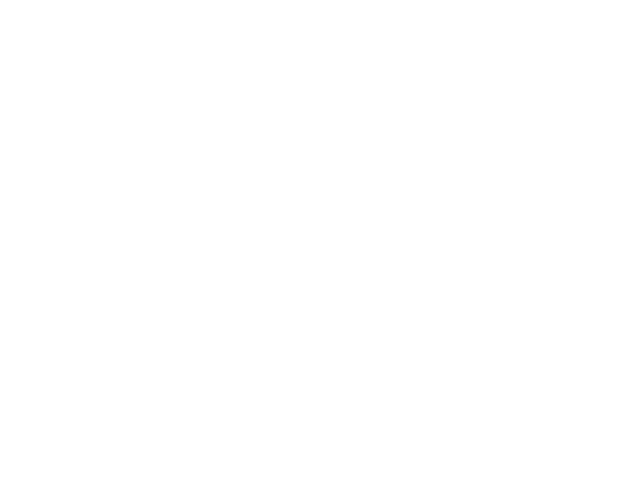

<IPython.core.display.Javascript object>


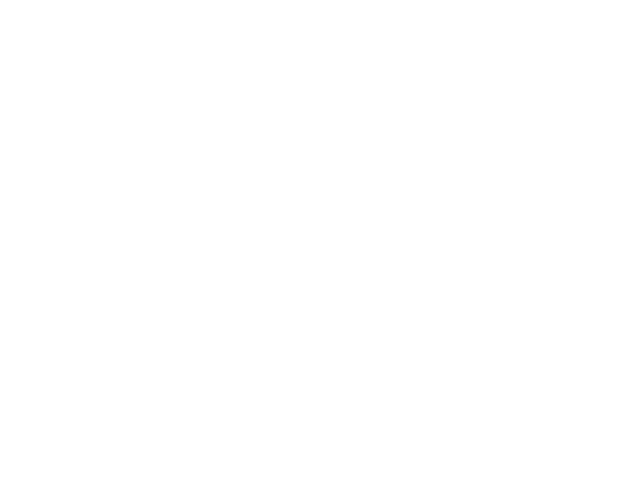

<IPython.core.display.Javascript object>


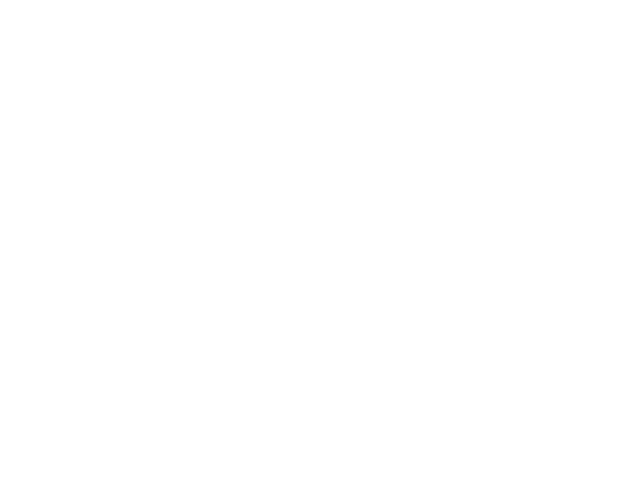

<IPython.core.display.Javascript object>


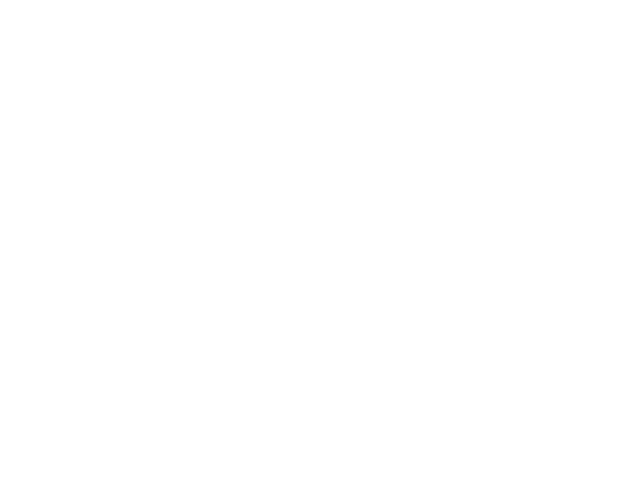

<IPython.core.display.Javascript object>


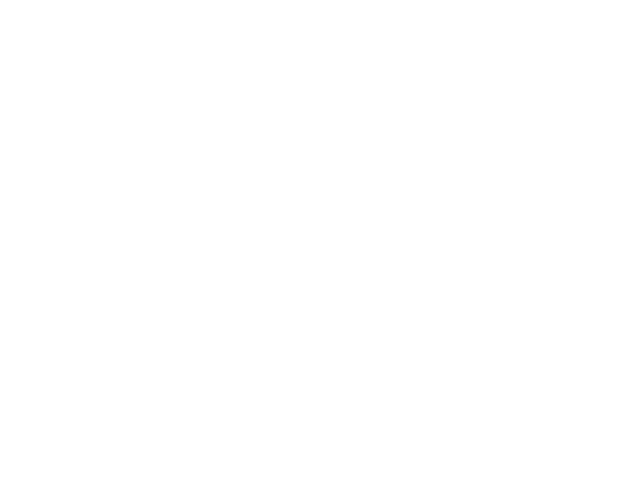

<IPython.core.display.Javascript object>


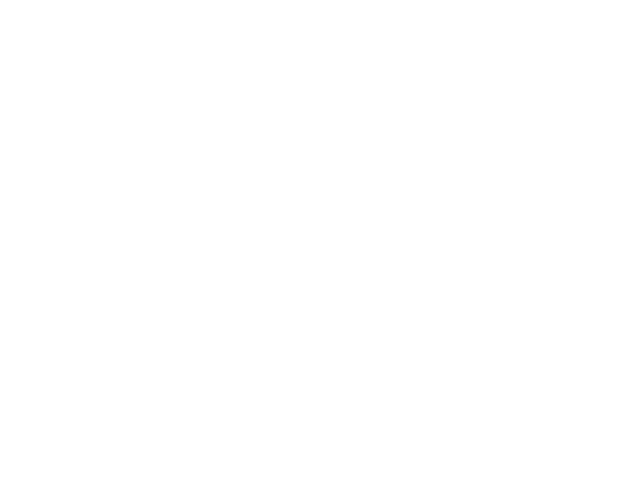

<IPython.core.display.Javascript object>


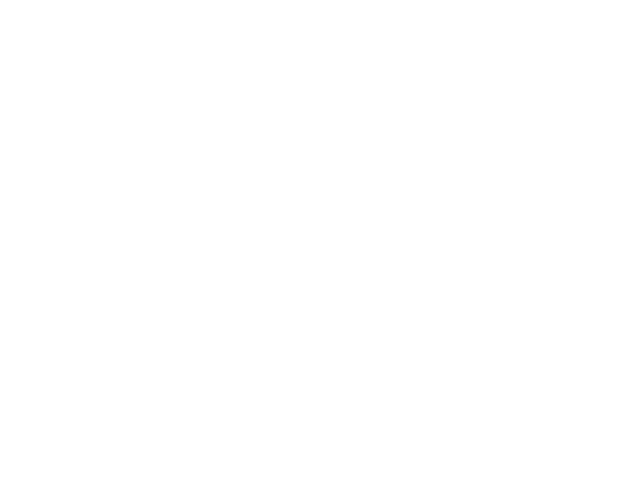

<IPython.core.display.Javascript object>


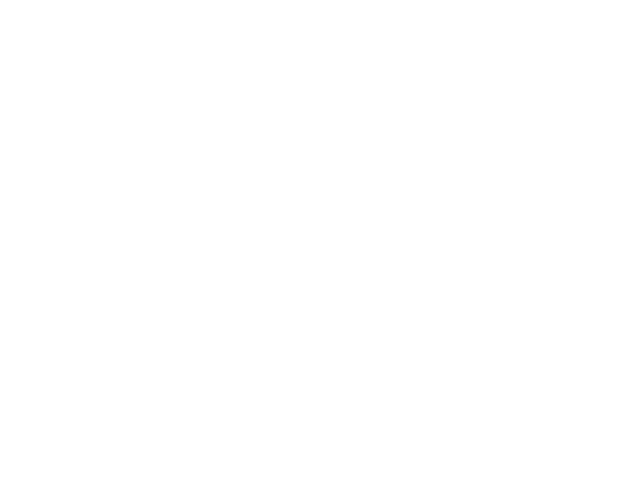

<IPython.core.display.Javascript object>


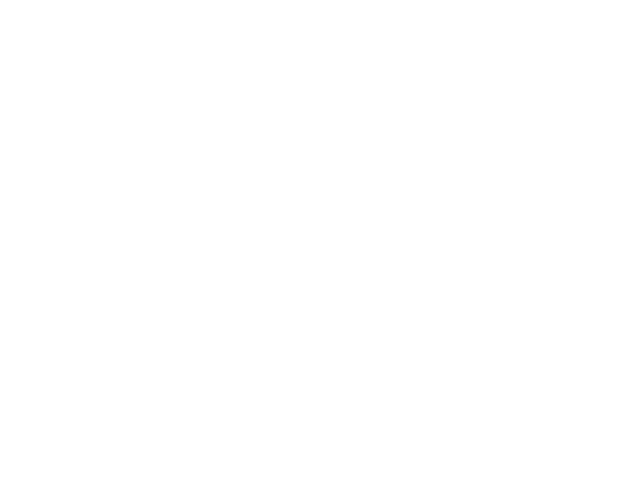

<IPython.core.display.Javascript object>


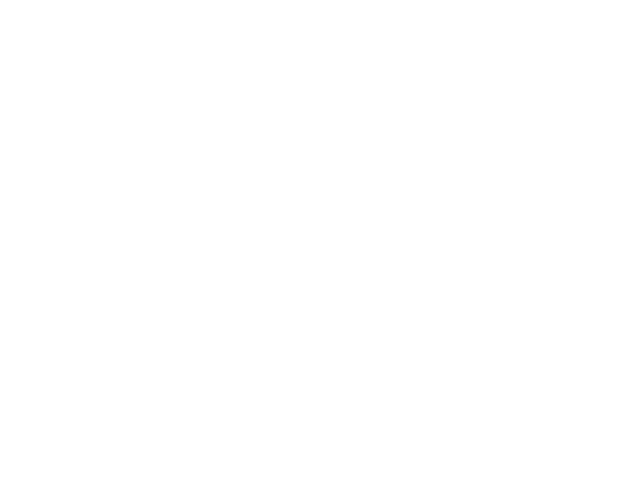

<IPython.core.display.Javascript object>


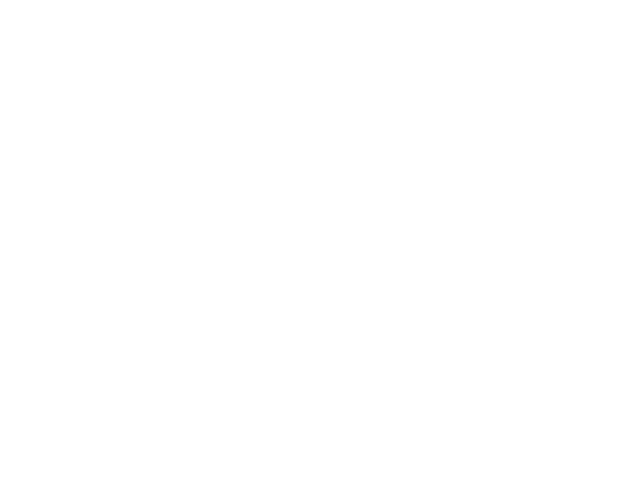

<IPython.core.display.Javascript object>


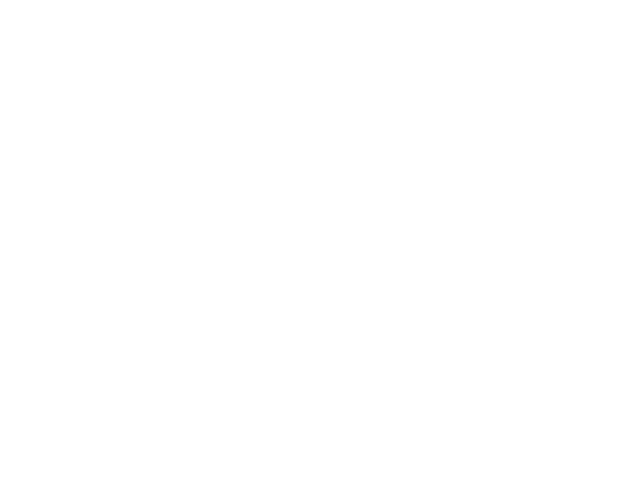

<IPython.core.display.Javascript object>


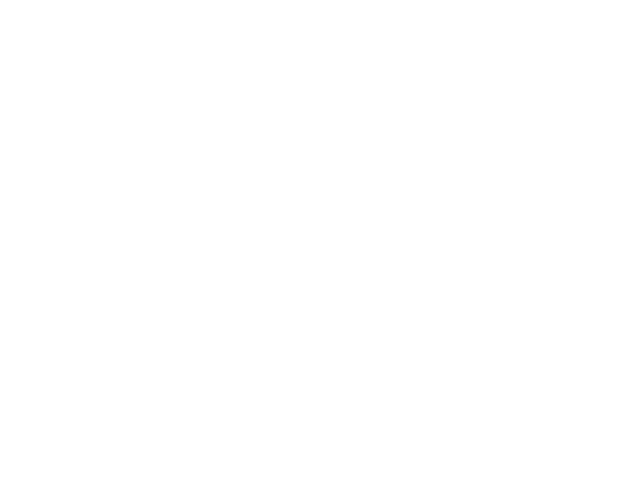

<IPython.core.display.Javascript object>


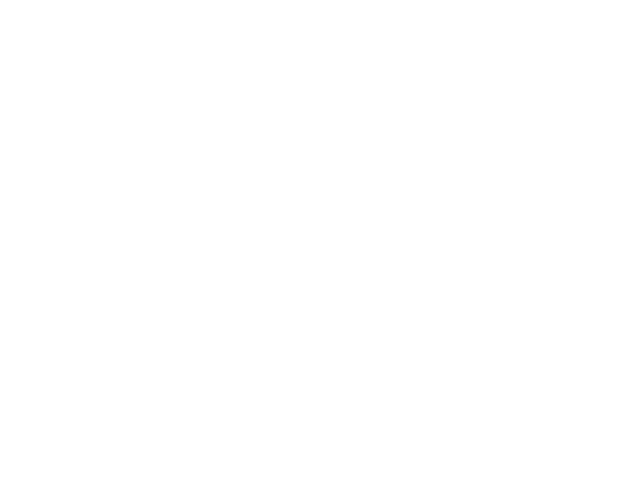

<IPython.core.display.Javascript object>


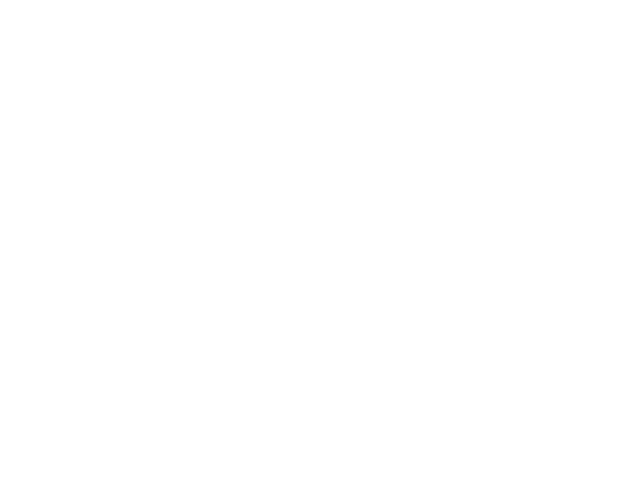

<IPython.core.display.Javascript object>


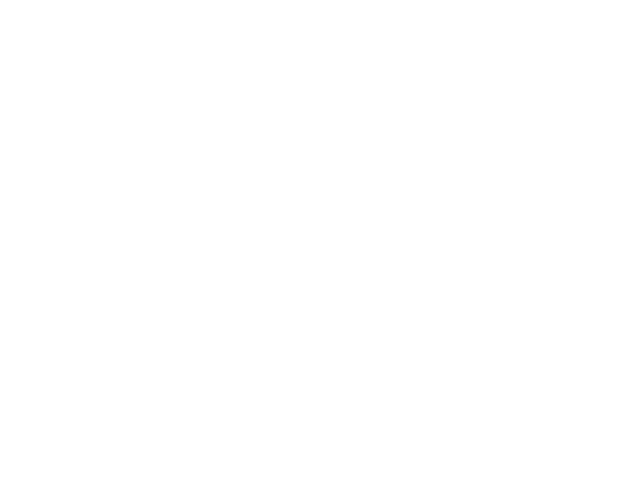

<IPython.core.display.Javascript object>


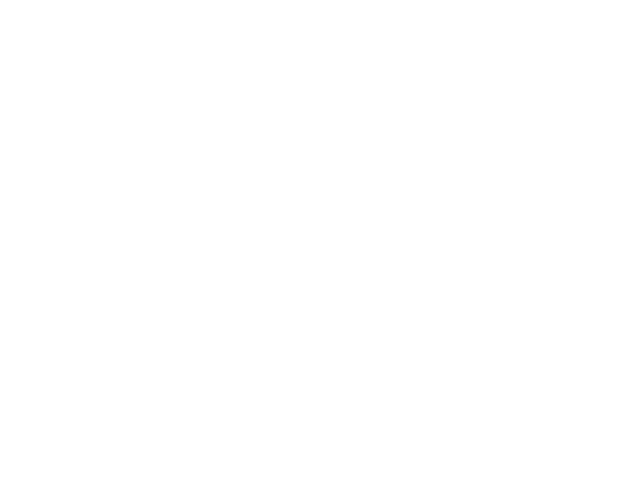

<IPython.core.display.Javascript object>


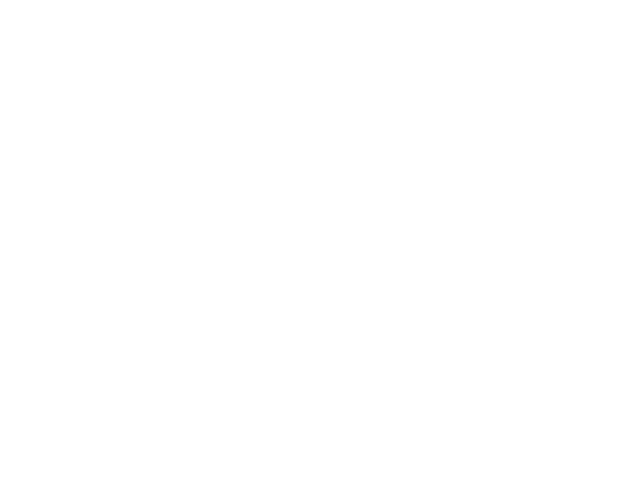

<IPython.core.display.Javascript object>


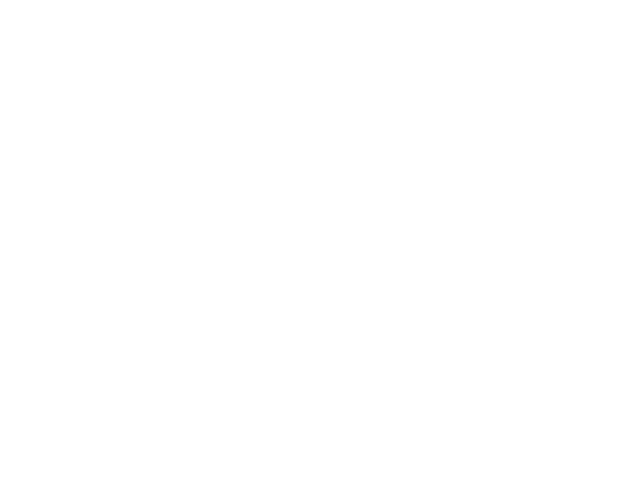

<IPython.core.display.Javascript object>


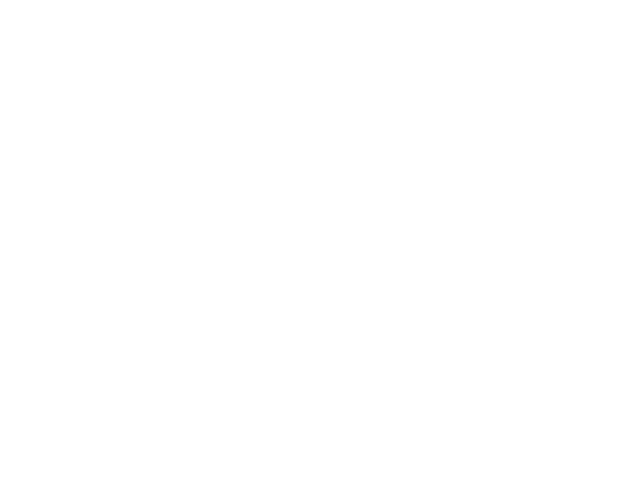

<IPython.core.display.Javascript object>


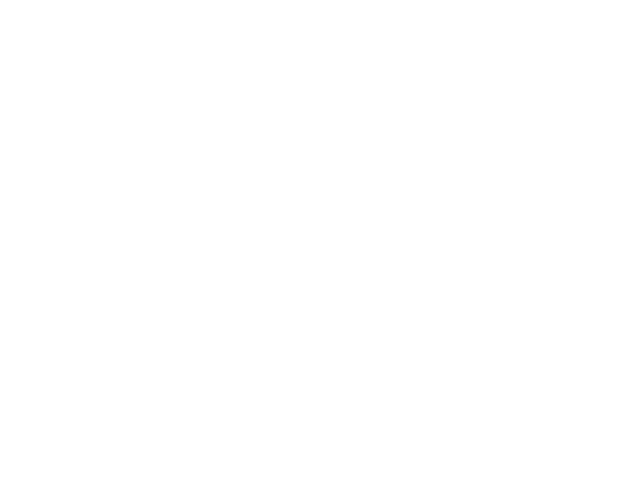

<IPython.core.display.Javascript object>


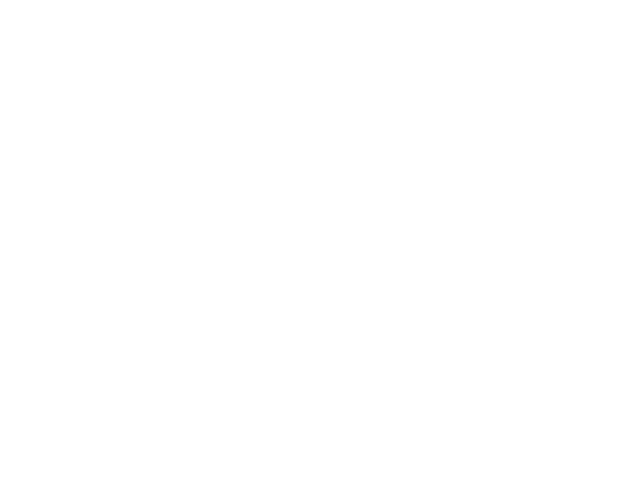

<IPython.core.display.Javascript object>


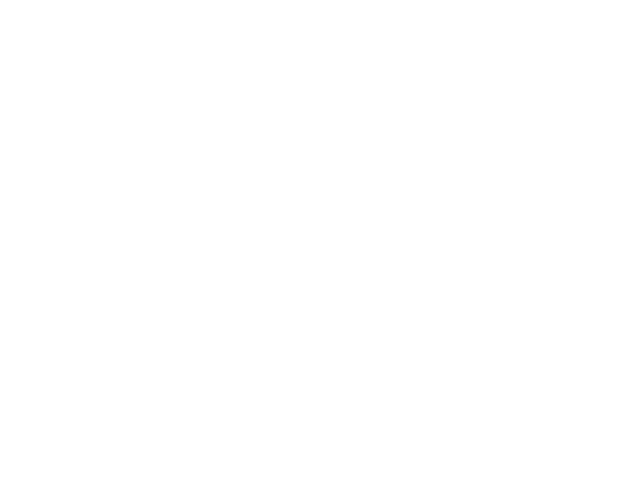

<IPython.core.display.Javascript object>


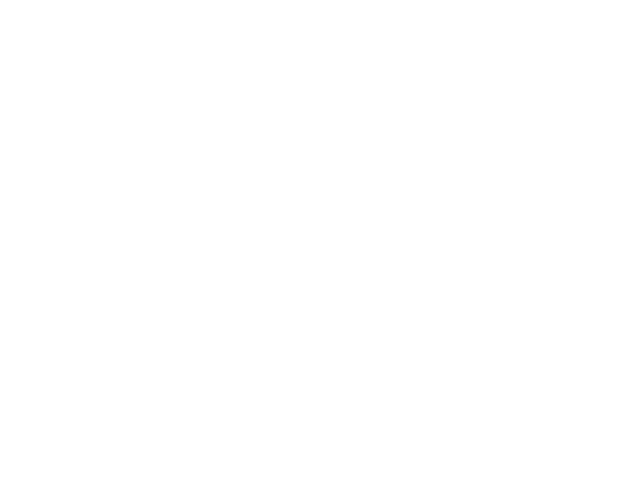

<IPython.core.display.Javascript object>


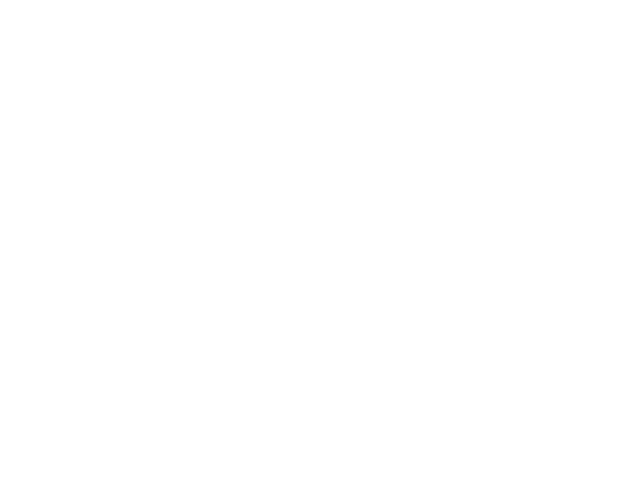

<IPython.core.display.Javascript object>


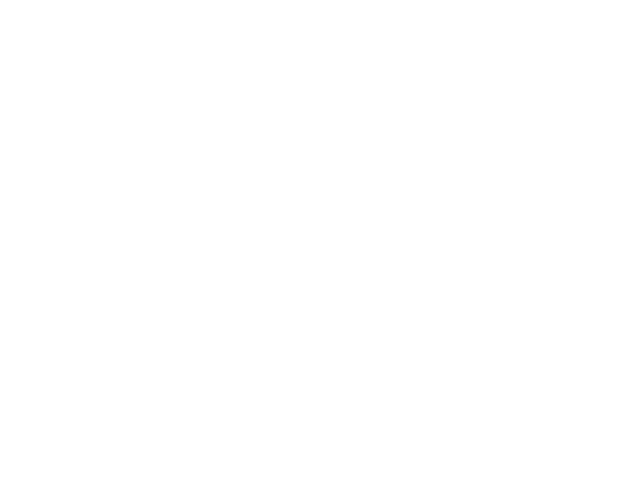

<IPython.core.display.Javascript object>


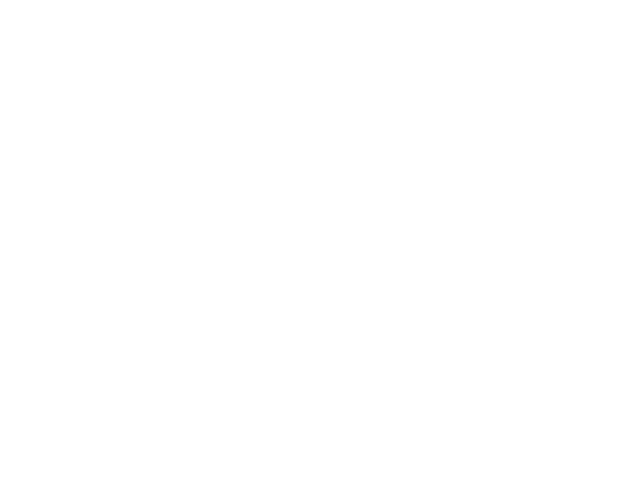

<IPython.core.display.Javascript object>


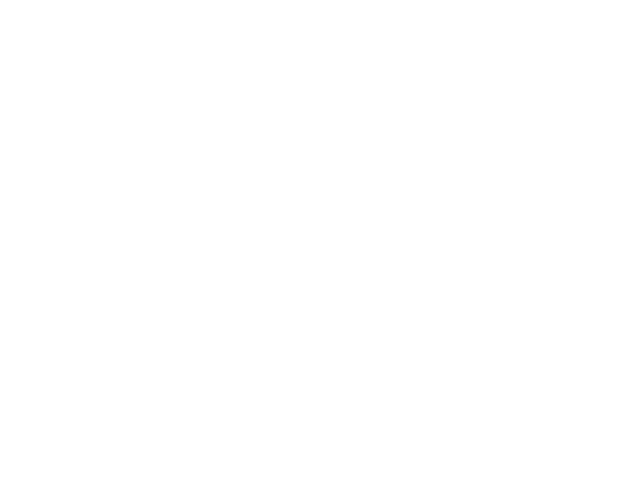

<IPython.core.display.Javascript object>


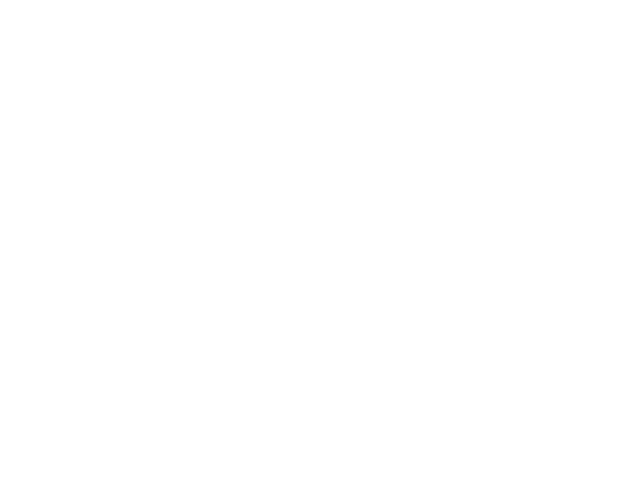

<IPython.core.display.Javascript object>


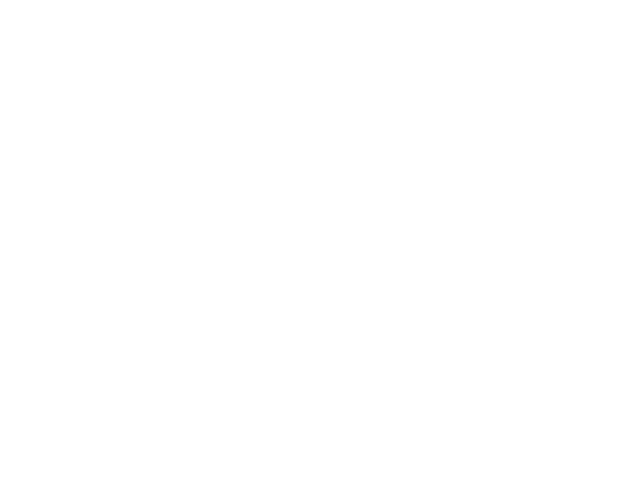

<IPython.core.display.Javascript object>


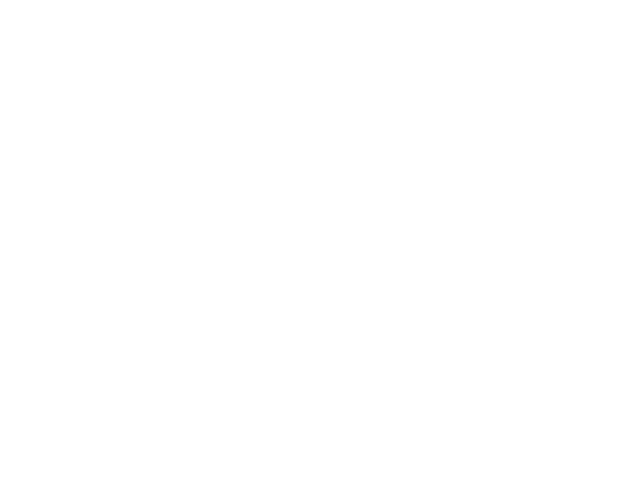

<IPython.core.display.Javascript object>


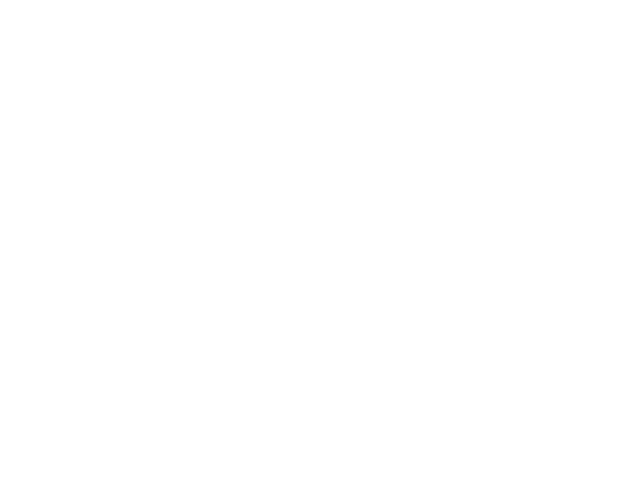

<IPython.core.display.Javascript object>


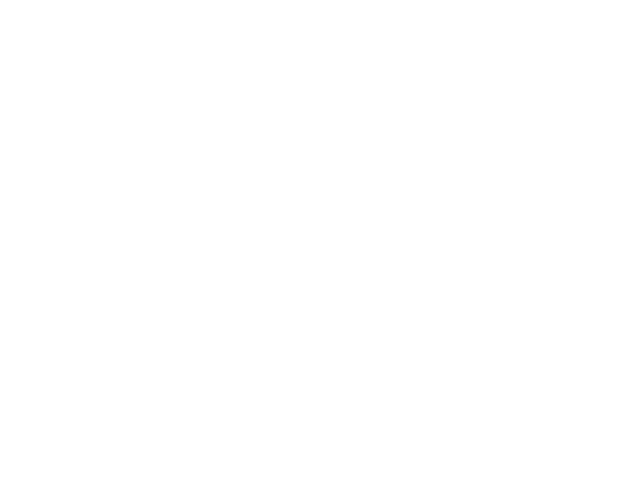

<IPython.core.display.Javascript object>


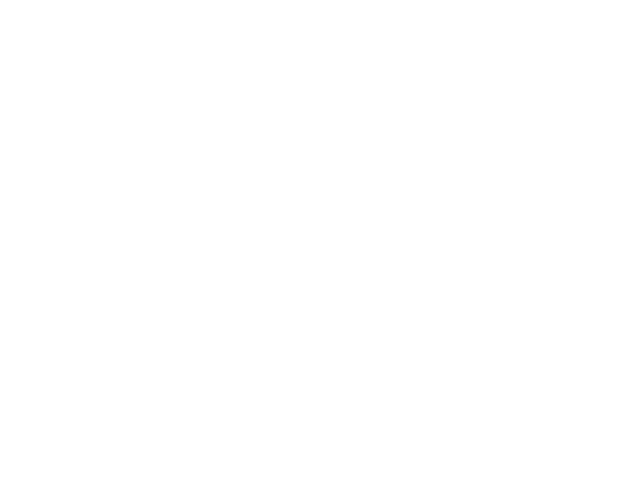

<IPython.core.display.Javascript object>


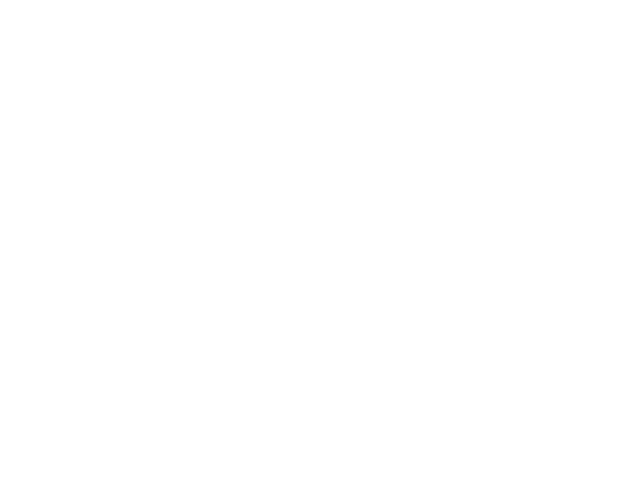

<IPython.core.display.Javascript object>


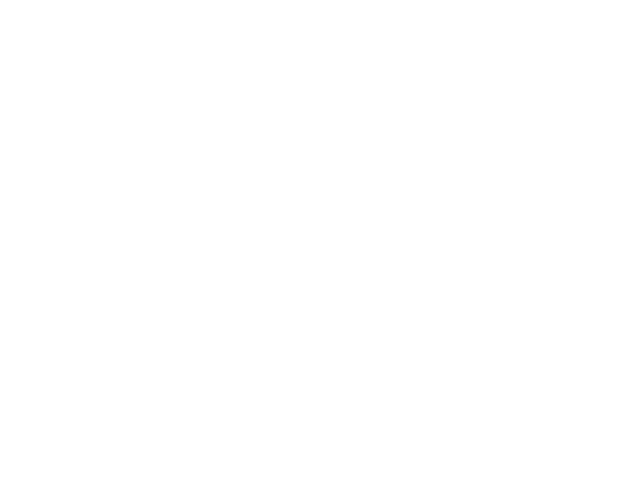

<IPython.core.display.Javascript object>


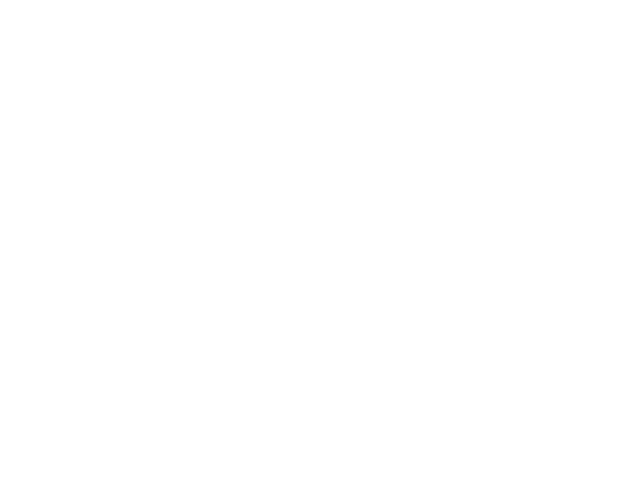

<IPython.core.display.Javascript object>


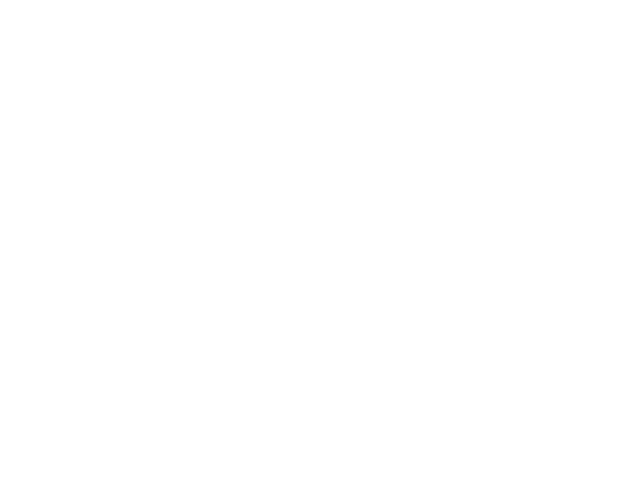

<IPython.core.display.Javascript object>


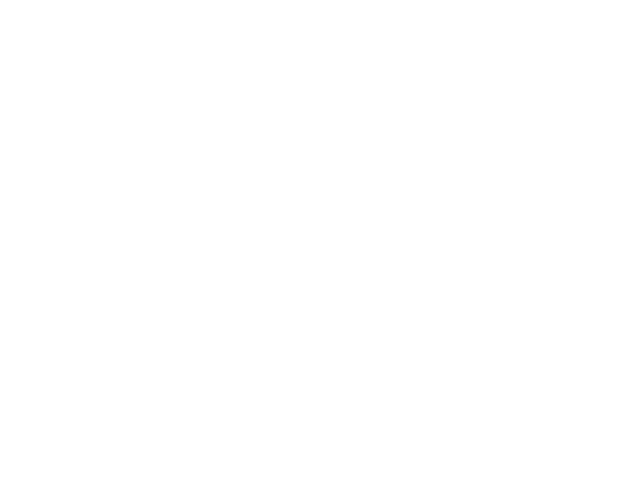

<IPython.core.display.Javascript object>


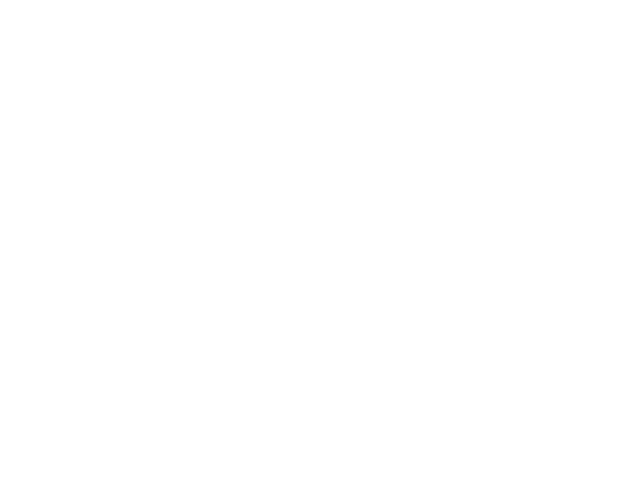

<IPython.core.display.Javascript object>


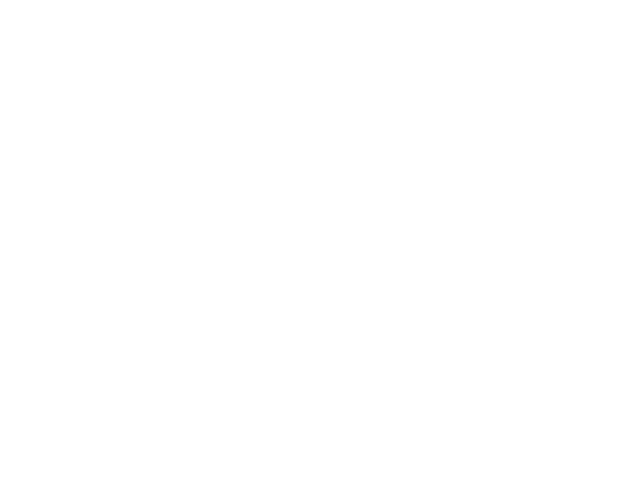

<IPython.core.display.Javascript object>


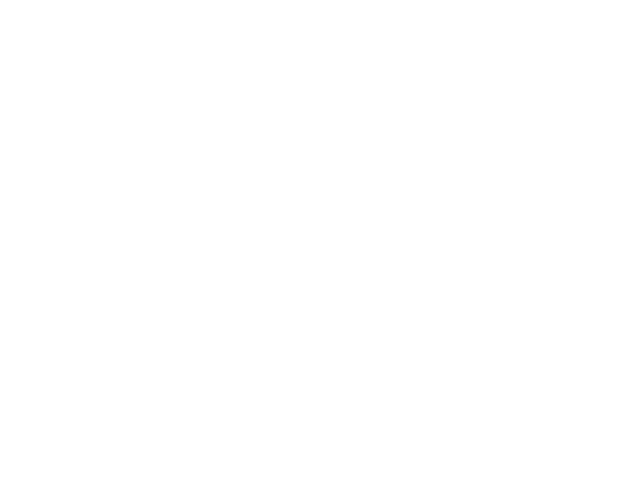

In [6]:
# generate demo videos
for i in range(0, len(data)):
    fig, ax = plt.subplots(2)
    ax[0].set_title("Torques w/ Sequential Data")
    ax[0].set_xlabel("Cut Number")
    ax[0].set_ylabel("Torque (Nm)")
    ax[0].plot(range(len(data)), actual_T, label = "Actual", linestyle='--')
    ax[0].plot(range(i + 1), pred_T[:1 + i], label = "Predicted")
    ax[0].legend()
    ax[0].label_outer()
    ax[1].set_title("Forces w/ Sequential Data")
    ax[1].set_xlabel("Cut Number")
    ax[1].set_ylabel("Force (N)")
    ax[1].plot(range(len(data)), actual_Fy, label = "Actual", linestyle='--')
    ax[1].plot(range(i + 1), pred_Fy[:1 + i], label = "Predicted")
    plt.savefig('generated_assets/frames/' + data_name + '_frame_' + str(i) + '.png', dpi = 300)
    plt.close(fig)